In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [9]:
folder = "energies"
num_replicas = 8
max_points = 10000 * 5

# Gráficas

In [12]:
def plotEnergyAtSpecificTemperature(temp: int, folder :str, show = True, save=False, figsize = (25, 10)):
    """
    Plotea la secuencia de energías en una temperatura específica.
    (Se ve como un time series)
    """
    filename = os.path.join(folder, f"energies_{temp}.txt")
    temperature = 0
    energies = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        temperature = float(lines[0].strip())
        energies = [float(line.strip()) for line in lines[1:max_points+1]]
    plt.figure(figsize=figsize)
    plt.plot(energies, label=f"T = {temperature:.3f}")
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Energy")
    plt.title(f"Parallel Tempering: Energy evolution at T = {temperature:.3f} (first {max_points} steps)")
    plt.grid(True)
    if save:
        plots_folder = "plots"
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f"energy_plot_T{temperature:.3f}.png")
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")
    if show:
        plt.show()
    else:
        plt.close()
    

In [13]:
for i in range(num_replicas):
    plotEnergyAtSpecificTemperature(i, folder, False, True)

Plot saved to plots\energy_plot_T1.000.png
Plot saved to plots\energy_plot_T1.219.png
Plot saved to plots\energy_plot_T1.486.png
Plot saved to plots\energy_plot_T1.811.png
Plot saved to plots\energy_plot_T2.208.png
Plot saved to plots\energy_plot_T2.692.png
Plot saved to plots\energy_plot_T3.281.png
Plot saved to plots\energy_plot_T4.000.png


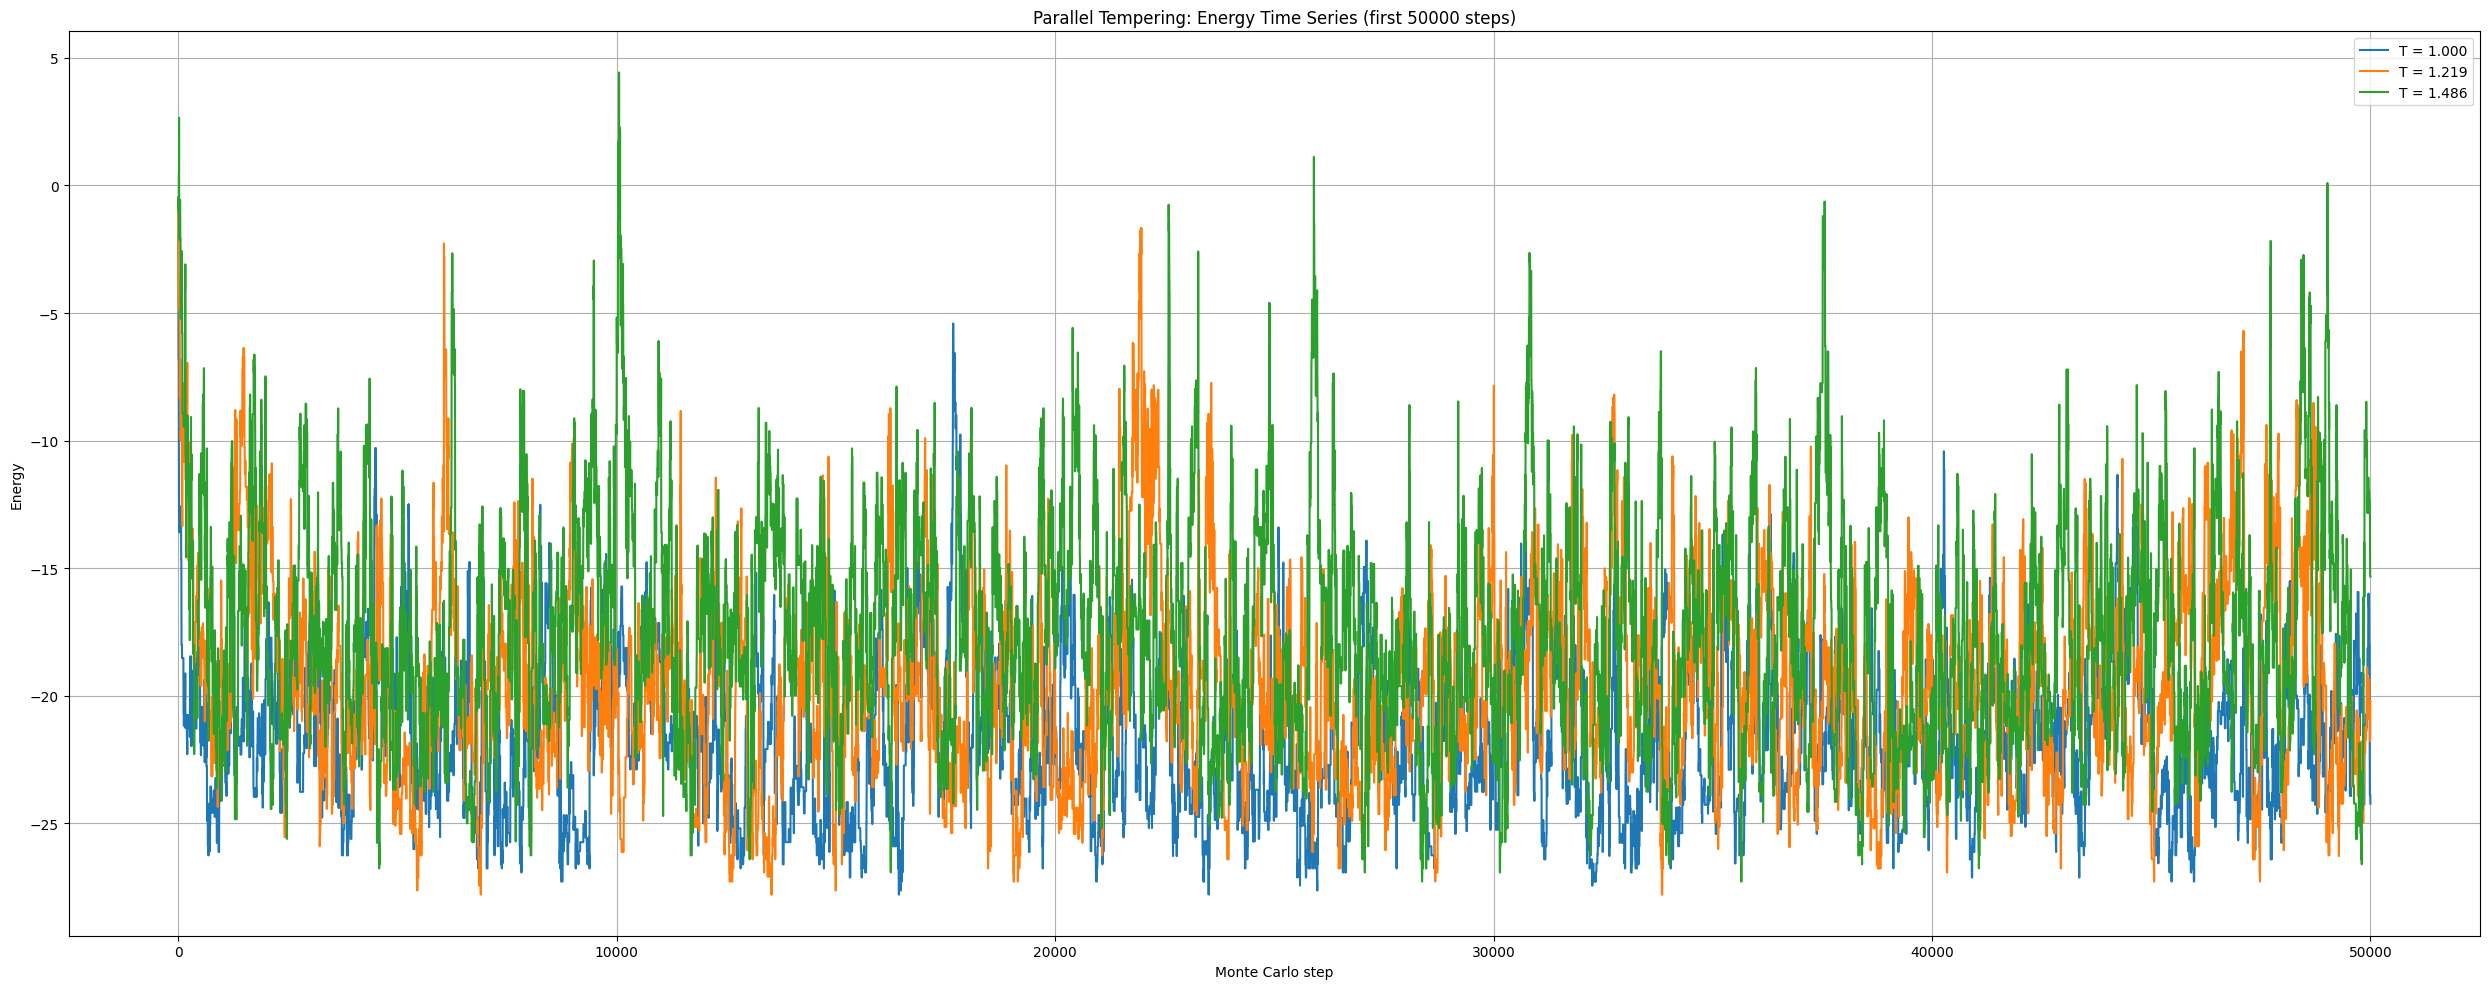

In [16]:
energy_data = []
temperatures = []
# muestra las energías
replicas_to_plot = 3
for i in range(replicas_to_plot):
    filename = os.path.join(folder, f"energies_{i}.txt")
    with open(filename, 'r') as file:
        lines = file.readlines()
        temperature = float(lines[0].strip())
        energies = [float(line.strip()) for line in lines[1:max_points+1]]  # +1 to skip temperature line
        temperatures.append(temperature)
        energy_data.append(energies)

# Plotting
plt.figure(figsize=(25, 10))
for i in range(replicas_to_plot):
    plt.plot(energy_data[i], label=f"T = {temperatures[i]:.3f}")

plt.xlabel("Monte Carlo step")
plt.ylabel("Energy")
plt.title(f"Parallel Tempering: Energy Time Series (first {max_points} steps)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Autocorrelación

Para un observable A(t), la función de autocorrelación es:

$$
C_A(\tau) = \frac{\langle A(t)A(t + \tau) \rangle - \langle A(t) \rangle ^2}{\langle A(t) ^2 \rangle - \langle A(t)  \rangle ^2}
$$

El tiempo de autocorrelación nos da la cantidad de Monte Carlo Sweeps (MCS) que hay que hacer para que dos elementos de la cadena de Markov no estén correlacionados (o al menos no fuertemente?). Se calcula:

$$
\tau^{int}_{auto} = \frac{1}{2} + \sum_{\tau = 1}^{\infty} C_A(\tau)
$$

Como no podemos sumar hasta infinito, sumamos hasta ```max_lag```.





In [17]:
def calculateAutocorrelation(energies, max_lag: int):
    """
    energies: array que representa la secuencia de energías
    max_lag: entero hasta el que se considera tau
    """
    N = len(energies)
    E_mean = np.mean(energies)
    E_var = np.var(energies)

    C = np.zeros(max_lag)
    for tau in range(max_lag):
        C[tau] = np.mean((energies[:N - tau] - E_mean) * (energies[tau:] - E_mean)) / E_var
    
    return C

def integrated_time(C):
    """
    C: array de autocorrelaciones
    """
    tau_int = 0.5
    for tau in range(1, len(C)):
        if C[tau] <= 0: break
        tau_int += C[tau]
    return tau_int

def autocorrelation_and_integrated_time_by_replica(folder: str, max_lag: int):
    for i in range(num_replicas):
        filename = os.path.join(folder, f"energies_{i}.txt")
        with open(filename, 'r') as file:
            lines = file.readlines()
            temperature = float(lines[0].strip())
            energies = np.array([float(line.strip()) for line in lines[1:max_points+1]])
        C = calculateAutocorrelation(energies, max_lag)
        tau_int = integrated_time(C)
        print(f"Integrated time (tau_int) for T{i} = {temperature:.3f}:", tau_int)


In [18]:
autocorrelation_and_integrated_time_by_replica(folder, 30)

Integrated time (tau_int) for T0 = 1.000: 25.285479684863724
Integrated time (tau_int) for T1 = 1.219: 25.294611781964413
Integrated time (tau_int) for T2 = 1.486: 24.95971400500658
Integrated time (tau_int) for T3 = 1.811: 23.345184641231125
Integrated time (tau_int) for T4 = 2.208: 22.688901467347804
Integrated time (tau_int) for T5 = 2.692: 21.77955016490615
Integrated time (tau_int) for T6 = 3.281: 22.05553563098419
Integrated time (tau_int) for T7 = 4.000: 20.55359922744457
